In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as cm
import seaborn as sns
import pandas as pd
import scipy.optimize as opt
import scipy.integrate as scint 

In [2]:
#read the experimental data from the csv file
DNAinc = pd.read_csv('../Data/rep char/DNAinc.csv')
RNA3inc = pd.read_csv('../Data/rep char/RNA3inc.csv')
RNA5inc = pd.read_csv('../Data/rep char/RNA5inc.csv')

#read the positive control data from the csv file
FAM_decay = pd.read_csv('../Data/controls/FAM_decay.csv')

#read the initial signal data from the csv file
initial_signal = pd.read_csv('../Data/controls/initial_signal.csv')

#convert data to numpy arrays
DNAinc = np.array(DNAinc)
RNA3inc = np.array(RNA3inc)
RNA5inc = np.array(RNA5inc)
FAM_decay = np.array(FAM_decay)
initial_signal = np.array(initial_signal)

In [3]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_rep):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_rep: reporter rate constant 
    :type k_rep: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    O = concs_init[0]
    FQ = concs_init[1]
    OQ = concs_init[2]
    F = concs_init[3]

    dO_dt = - k_rep*O*FQ 
    dFQ_dt = dO_dt 
    dOQ_dt = - dO_dt
    dF_dt = - dO_dt
    
    return [dO_dt, dFQ_dt, dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_rep, alpha):
    """SOLVES A SYSTEM OF ODES THROUGH NUMERICAL INTEGRATION
    :param t: time over which the experiment was performed
    :type t: array
    :param k_rep: reporter rate constant 
    :type k_rep: int, float
    :param alpha: scaling constant
    :type alpha: int, float
    :return: numerical integration for the concentration of the fluorescently-labelled single strand over time"""
    O_init = alpha*60*10**-9
    FQ_init = alpha*60*10**-9
    OQ_init = 0
    F_init = 0
        
    concs_init = [O_init, FQ_init, OQ_init, F_init]
    
    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_rep,), hmax = 20)
    return soln[:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6, 0.8], bounds=([1., 0],[8.,1.]))
    return popt, pcov

krep =  5.54333326901057
alpha =  0.8418124777021625
[0.00349616 0.0005049 ]
krep =  4.142938442469197
alpha =  0.9123508409928485
[0.00090992 0.00056656]
krep =  5.029933087668947
alpha =  0.8606463217235629
[0.00066379 0.00016656]


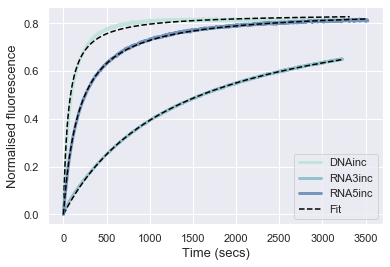

In [4]:
#average across the three replicates
sns.set()
plt.figure()
labels = ['DNAinc', 'RNA3inc', 'RNA5inc']
color = sns.cubehelix_palette(start = 0.6, rot=-.5)
toehold_lengths = [DNAinc, RNA3inc, RNA5inc]

#loop through the 3 reporter characterisation experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time = np.empty((len(th_len[:, 0]), 3))
    fluor = np.empty((len(th_len[:, 0]), 3))
    
    #fill the matrices the with the data for the three reporter characterisation experiments
    time[:, ind] = th_len[:,0]
    fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    
    FAM_decay_time = FAM_decay[:, 0].tolist()
    time_time = time[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time[0, ind]:     
        start_time = FAM_decay_time.index(time[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]), 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[:, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:, ind], time[0, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[:end_time+1, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:end_time + 1, ind], time[0, ind])
        #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time_time.index(FAM_decay[0, 0])
                #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[start_time, ind]))
            time_molar = np.subtract(time[start_time:, ind], time[start_time, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]), 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:end_time+1, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[start_time, ind])) 
            time_molar = np.subtract(time[start_time:end_time+1, ind], time[start_time, ind])

    '''#plot the average fluorescence against time
    plt.plot(time[:, ind], fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()

    #plot the average normalised fluorescence against time
    plt.plot(time_molar, molar_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()'''
    
    #fit the experimental data to the bimolecular model using numerical integration 
    popt, pcov = fit_TMSD(time_molar, molar_fluor[:, ind])
    print('krep = ', popt[0])
    print('alpha = ', popt[1])
    #print(pcov)
    #determine one standard deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)

    TMSD_sol = solve_TMSD(time_molar, *popt)
    
    #plot the numerical integration and the fits
    plt.plot(time_molar, molar_fluor[:, ind], color = color[ind], linewidth = 3, label = labels[ind])
    if ind == 0:
        plt.plot(time_molar, TMSD_sol,'--', c = 'black', label = 'Fit')
    else: 
        plt.plot(time_molar, TMSD_sol,'--', c = 'black')
        
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[3], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[1]]

ax.legend(handles,labels,loc='lower right')

plt.xlabel('Time (secs)', fontsize = 13, fontname = 'Arial')  
plt.ylabel('Normalised fluorescence', fontsize = 13, fontname = 'Arial')
plt.savefig('rep char keff no_init.svg')
plt.show()